In [16]:
import sys
import importlib
import scanpy as sc
import numpy as np

sys.path.append("..")
# import masking script
import scripts.dropout_masking as dm
importlib.reload(dm)

# Sanity checks
print("Train adata:", adata_train.shape)
print("layers:", list(adata_train.layers.keys()))
assert "counts" in adata_train.layers, "counts layer is required for SCVI."

Train adata: (447, 51777)
layers: ['counts', 'log2_1p_CPM_original']


In [17]:
def run_masking(in_path, out_path, frac=(0.10, 0.20), thin_p=0.2, seed=2):
    """Apply dropout masking to one dataset and save result."""
    # Load
    adata = sc.read_h5ad(in_path)

    # Keep a copy of the original counts for evaluation later
    adata.layers["counts_orig"] = dm._to_csr(adata.layers["counts"]).copy()

    # Use batch key if present
    batch_key = "cohort" if "cohort" in adata.obs.columns else None

    # Build mask
    mask_w = dm.make_masks(
        adata,
        layer="counts",
        mode="expr_weighted",
        frac=frac,
        per_sample=True,
        by_batch_key=batch_key,
        weight_alpha=1.0,
        rng_seed=seed,
        return_sparse=True,
    )
    adata.layers["mask_weighted"] = mask_w

    # Apply masking
    dm.apply_mask(adata, mask_w, layer="counts", to="counts_masked",
                  strategy="zero", rng_seed=seed)
    dm.apply_mask(adata, mask_w, layer="counts", to="counts_masked_thin",
                  strategy="thin", thin_p=thin_p, rng_seed=seed)

    # Save meta info
    X0 = dm._to_csr(adata.layers["counts_orig"])
    masked_nnz = (X0.multiply(mask_w)).nnz
    adata.uns["masking_meta"] = {
        "mode": "expr_weighted",
        "frac": list(frac),
        "thin_p": thin_p,
        "rng_seed": seed,
        "batch_key": batch_key,
        "masked_nonzeros": masked_nnz,
        "total_nonzeros": X0.nnz,
        "masked_rate_over_nnz": masked_nnz / max(1, X0.nnz),
    }

    # Save
    adata.write(out_path)
    print(f"Saved: {out_path}")


In [13]:
DATA_ROOT = "../data/processed/scvi_prepared"
datasets = [
    "GSE169569_raw_counts.h5ad",
    "GSE169569_topmean4000.h5ad",
    "GSE169569_hvg4000.h5ad",
]

In [14]:
for fname in datasets:
    in_path = f"{DATA_ROOT}/{fname}"
    p = Path(in_path)
    out_path = str(p.with_name(p.stem + "_masked" + p.suffix))  # Always append _masked before .h5ad
    run_masking(in_path, out_path, frac=(0.10, 0.20), thin_p=0.2, seed=2)

Saved: ../data/processed/scvi_prepared/GSE169569_raw_counts_masked.h5ad
Saved: ../data/processed/scvi_prepared/GSE169569_topmean4000_masked.h5ad
Saved: ../data/processed/scvi_prepared/GSE169569_hvg4000_masked.h5ad


In [21]:
print("layers:", list(adata.layers.keys()))
print(".X shape:", adata.X.shape)
print("has .raw?:", adata.raw is not None)
if adata.raw is not None:
    print(".raw.X shape:", adata.raw.X.shape)

layers: ['counts', 'log2_1p_CPM_original']
.X shape: (447, 4000)
has .raw?: False



=== Loading: ../data/processed/scvi_prepared/GSE169569_raw_counts.h5ad ===

[GSE169569_raw_counts.h5ad] Skipped: counts_masked not found.
[GSE169569_raw_counts.h5ad] Skipped: counts_masked_thin not found.

=== Loading: ../data/processed/scvi_prepared/GSE169569_topmean4000_masked.h5ad ===

[GSE169569_topmean4000_masked.h5ad] Visualizing: counts_masked


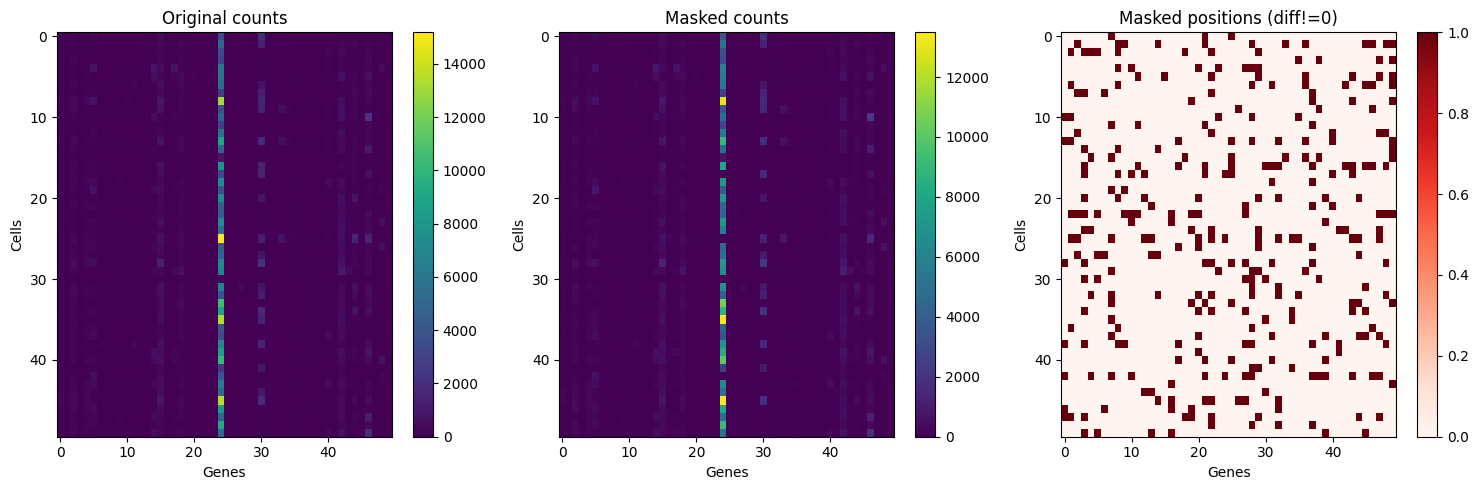

[GSE169569_topmean4000_masked.h5ad] Visualizing: counts_masked_thin


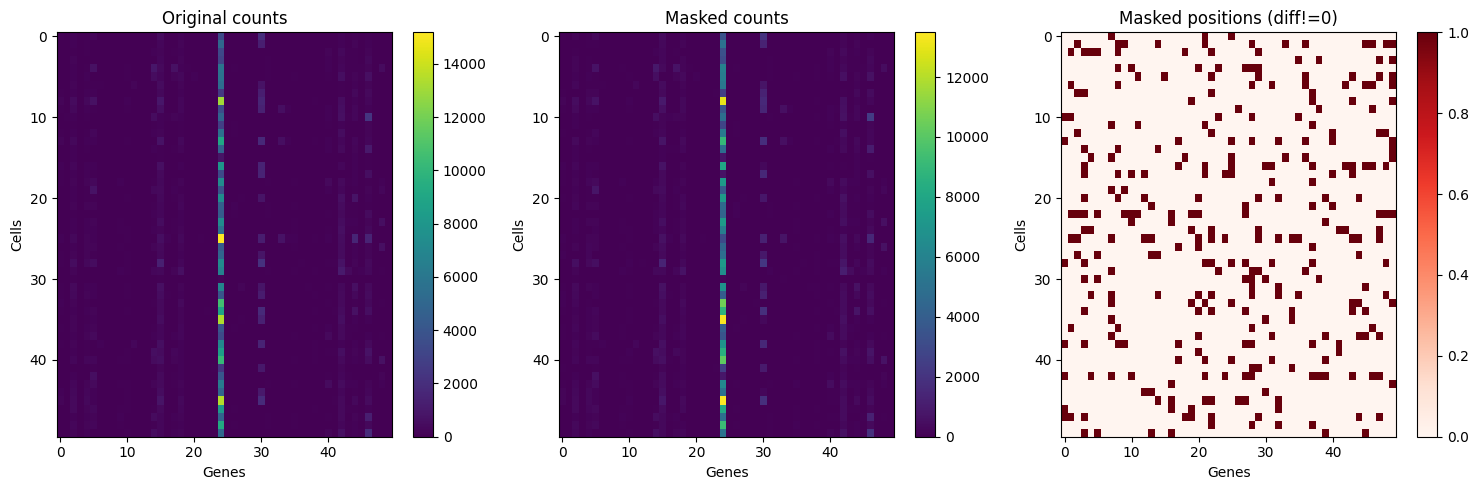


=== Loading: ../data/processed/scvi_prepared/GSE169569_hvg4000_masked.h5ad ===

[GSE169569_hvg4000_masked.h5ad] Visualizing: counts_masked


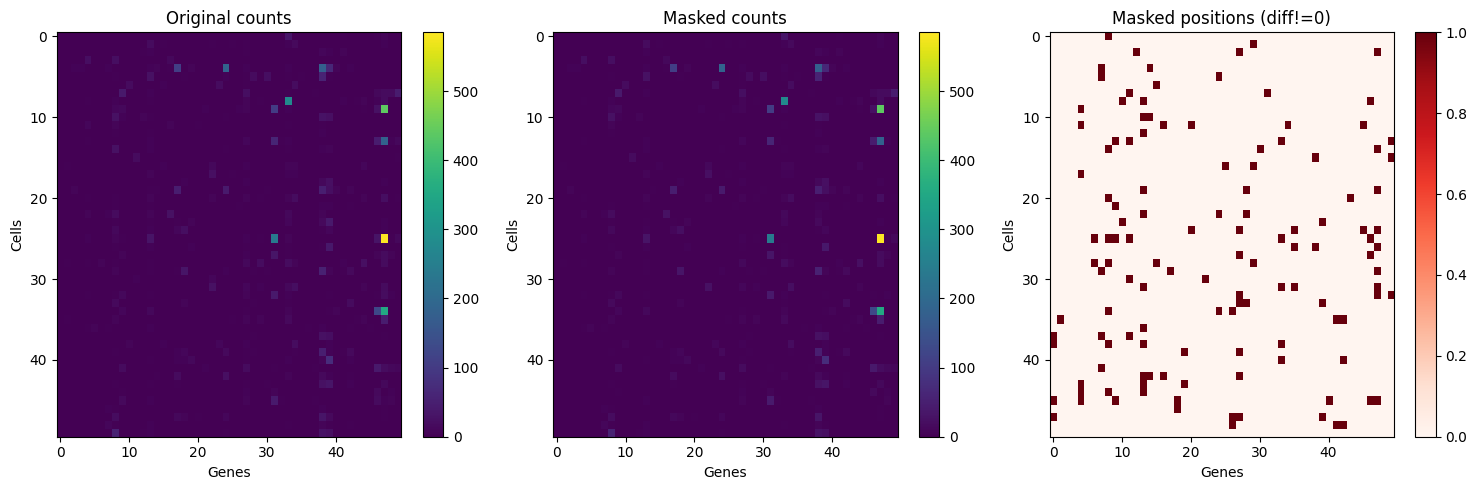

[GSE169569_hvg4000_masked.h5ad] Visualizing: counts_masked_thin


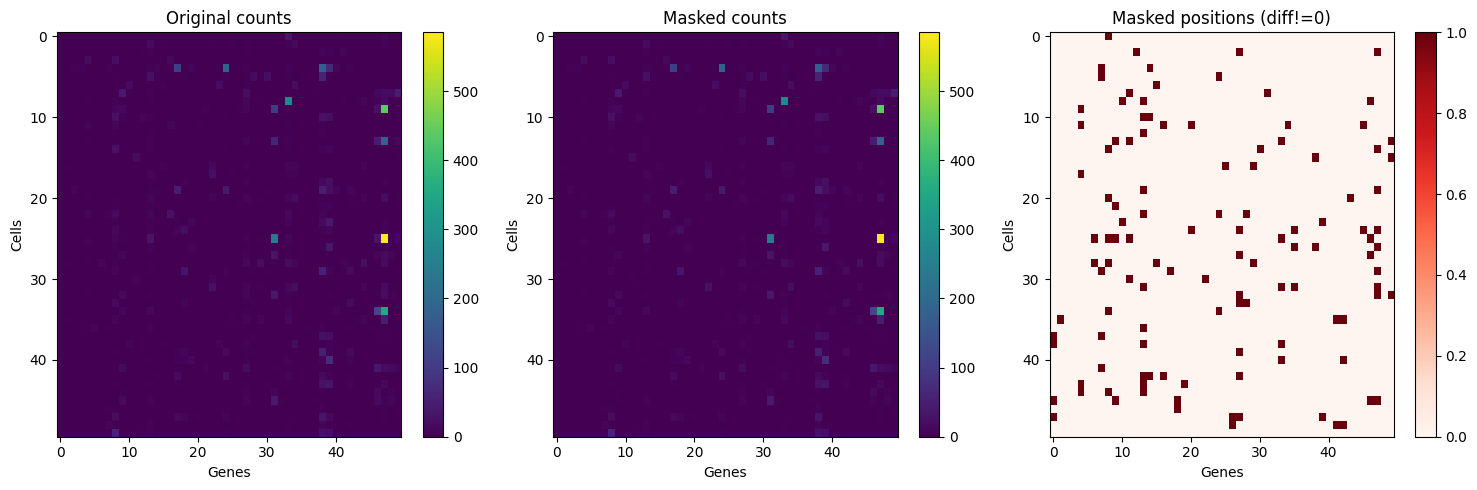

In [25]:
from pathlib import Path
# --- Files to check (use your exact saved paths) ---
DATA_ROOT = "../data/processed/scvi_prepared"
files = [
    f"{DATA_ROOT}/GSE169569_raw_counts.h5ad",
    f"{DATA_ROOT}/GSE169569_topmean4000_masked.h5ad",
    f"{DATA_ROOT}/GSE169569_hvg4000_masked.h5ad",
]

# --- Helper: visualize both zero and thin masked layers if present ---
def show_all_masks(adata, title_prefix="", n_cells=50, n_genes=50, seed=0):
    """Show original vs masked for both 'counts_masked' and 'counts_masked_thin' if available."""
    # Ensure counts_orig exists
    if "counts_orig" not in adata.layers:
        raise KeyError("counts_orig layer not found. Make sure you saved it with the masked file.")
    
    # 1) Zeroed version
    if "counts_masked" in adata.layers:
        print(f"\n[{title_prefix}] Visualizing: counts_masked")
        dm.compare_original_masked(
            adata,
            orig_layer="counts_orig",
            masked_layer="counts_masked",
            n_cells=n_cells,
            n_genes=n_genes,
        )
    else:
        print(f"\n[{title_prefix}] Skipped: counts_masked not found.")
    
    # 2) Thinned version
    if "counts_masked_thin" in adata.layers:
        print(f"[{title_prefix}] Visualizing: counts_masked_thin")
        dm.compare_original_masked(
            adata,
            orig_layer="counts_orig",
            masked_layer="counts_masked_thin",
            n_cells=n_cells,
            n_genes=n_genes,
        )
    else:
        print(f"[{title_prefix}] Skipped: counts_masked_thin not found.")

# --- Loop through all files and visualize ---
for fp in files:
    if not Path(fp).exists():
        print(f"\n[WARN] File not found: {fp}")
        continue

    print(f"\n=== Loading: {fp} ===")
    adata = sc.read_h5ad(fp)

    if "counts_orig" not in adata.layers:
        if "counts" in adata.layers:
            adata.layers["counts_orig"] = adata.layers["counts"].copy()
        else:
            adata.layers["counts_orig"] = adata.X.copy()

    show_all_masks(adata, title_prefix=Path(fp).name, n_cells=50, n_genes=50, seed=0)